In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

In [2]:
%matplotlib inline

### Create DLA algorithm for 2D Matrix
- Here point aggregator is simulated
- additional funtion `DLA2D.trace_point()` is provided to trace the attachment of each point to graph
**pseudocode**

```
dla{
    initialize the matrix with needed parameter
    mark the start point
    generate a random point
    while (point not attached to adjacent)
        random walk around adjacent
    }
```

In [3]:
class DLA2d:
    def __init__(self, matrix_size, stickiness, points_to_generate):
        self.matrix_size = matrix_size
        self.stickiness = stickiness
        self.points_to_generate = points_to_generate
    
    def initialize_matrix(self):
        matrix = np.zeros((self.matrix_size, self.matrix_size), dtype=np.int32)
        # point aggregator
        matrix[self.matrix_size//2, self.matrix_size//2] = 255
        return matrix
    
    def get_adjacent_points(self, pos: tuple, padding: bool=True) -> list:
        x, y = pos
        adjacent_pos = [
            (x - 1, y - 1),
            (x - 1 if x-1 > -1 else self.matrix_size-1, y) if padding else (x - 1, y), #up
            (x - 1, y + 1),
            (x, y - 1 if y-1 > -1 else self.matrix_size-1) if padding else (x, y - 1), # left
            (x, y + 1 if y+1 < self.matrix_size else 0) if padding else (x, y + 1), # right
            (x + 1, y - 1),
            (x + 1 if x+1 < self.matrix_size else 0, y) if padding else (x +1, y), # down
            (x + 1, y + 1)]
        adjacent_pos = filter(
            lambda x: (x[0] > -1 and x[0] < self.matrix_size) and (x[1] > -1 and x[1] < self.matrix_size),
            adjacent_pos)
        return list(adjacent_pos)
    
    def get_random_pos(self, matrix: np.ndarray) -> tuple:
        new_pos = (self.matrix_size//2, self.matrix_size//2)
        while matrix[new_pos]==255:
            new_pos = tuple(np.random.randint(0, self.matrix_size, size=2))
        return new_pos, 1
    
    def start_random_walk(self, pos: tuple) -> tuple:
        # S(t) = S(t-1) + w(t)
        # w(t) is chosen from adjacent points with a probablistic inference from the distribution
        # TODO: Optimize the walk
        adj_pos = self.get_adjacent_points(pos)
        prob = np.random.rand()
        return adj_pos[np.random.randint(len(adj_pos))], prob if prob>0 else prob + 0.1
    
    def check_attachment(self, pos: tuple, prob: float, matrix: np.ndarray) -> bool:
        adjacent = self.get_adjacent_points(pos, padding=False)
        return any(filter(lambda x: matrix[x]==255, adjacent)) and prob < self.stickiness
    
    def generate_dla(self, matrix: np.ndarray):
        self.path = []
        for point in tqdm(range(self.points_to_generate)):
            point_path = []
            visit_matrix = np.zeros((self.matrix_size, self.matrix_size), dtype=np.int32)
            new_pos, prob = self.get_random_pos(matrix)
            visit_matrix[new_pos] = 1
            point_path.append(new_pos)
            while not self.check_attachment(new_pos, prob, matrix):
                while visit_matrix[new_pos]!=0:
                    new_pos, prob = self.start_random_walk(new_pos)
                point_path.append(new_pos)
                visit_matrix[new_pos] = 1
            matrix[new_pos] = 255
            self.path.append(point_path)
        return matrix
    
    def trace_point(self, point: int):
        data = np.empty((self.matrix_size, self.matrix_size), dtype=np.int32)
        data.fill(255)
        data[self.matrix_size//2, self.matrix_size//2] = np.random.randint(255)
        if point < len(self.path) and point > 0:
            for i in range(point):
                data[self.path[i][-1]] = np.random.randint(255)
            fig = plt.figure(figsize=(30, 30))
            ax = plt.axes(xlim=(0, self.matrix_size), ylim=(0, self.matrix_size))

            #plot the attached point/pixels till the recent point
            ax.imshow(data.transpose(), interpolation='nearest', cmap='gray')

            #mark the trace
            trace = self.path[point-1]
            x, y = trace[0]
            x_, y_ = trace[-1]

            #start marker
            ax.scatter(x, y, marker='*', s=20*2*6, c='#17202A')

            #end marker
            ax.scatter(x_, y_, marker='*', s=20*4*6, c='#f20c27')

            #trace curve
            X, Y = zip(*trace)
            line, = ax.plot(X, Y, lw=2, color='#0492C2')
            ax.set_xticks(np.arange(0, self.matrix_size, 20))
            ax.set_yticks(np.arange(0, self.matrix_size, 20))
            ax.set_title('Random walk (Point Aggregator)', fontsize=22)
            ax.set_xlabel('X-coordinate', fontsize=18)
            ax.set_ylabel('Y-coordinate', fontsize=18)
            ax.tick_params(labelsize=16)
            return 1
        else:
            print("Point number exceeds/underweighs points present in the matrix.")
            return 0

## Task 1: Simulation of DLA for a given value of stickiness.

In [4]:
new_dla = DLA2d(matrix_size=200, stickiness=1, points_to_generate=200)
new_matrix = new_dla.initialize_matrix()
mod_matrix = new_dla.generate_dla(matrix=copy.deepcopy(new_matrix))

100%|██████████| 200/200 [02:02<00:00,  1.63it/s]


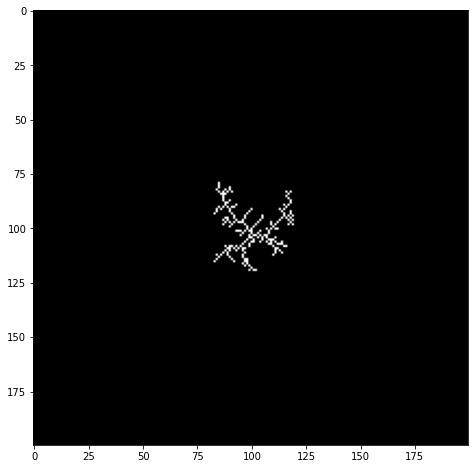

In [5]:
plt.figure(figsize=(8,8))
plt.imshow(mod_matrix, cmap = 'gray')

1

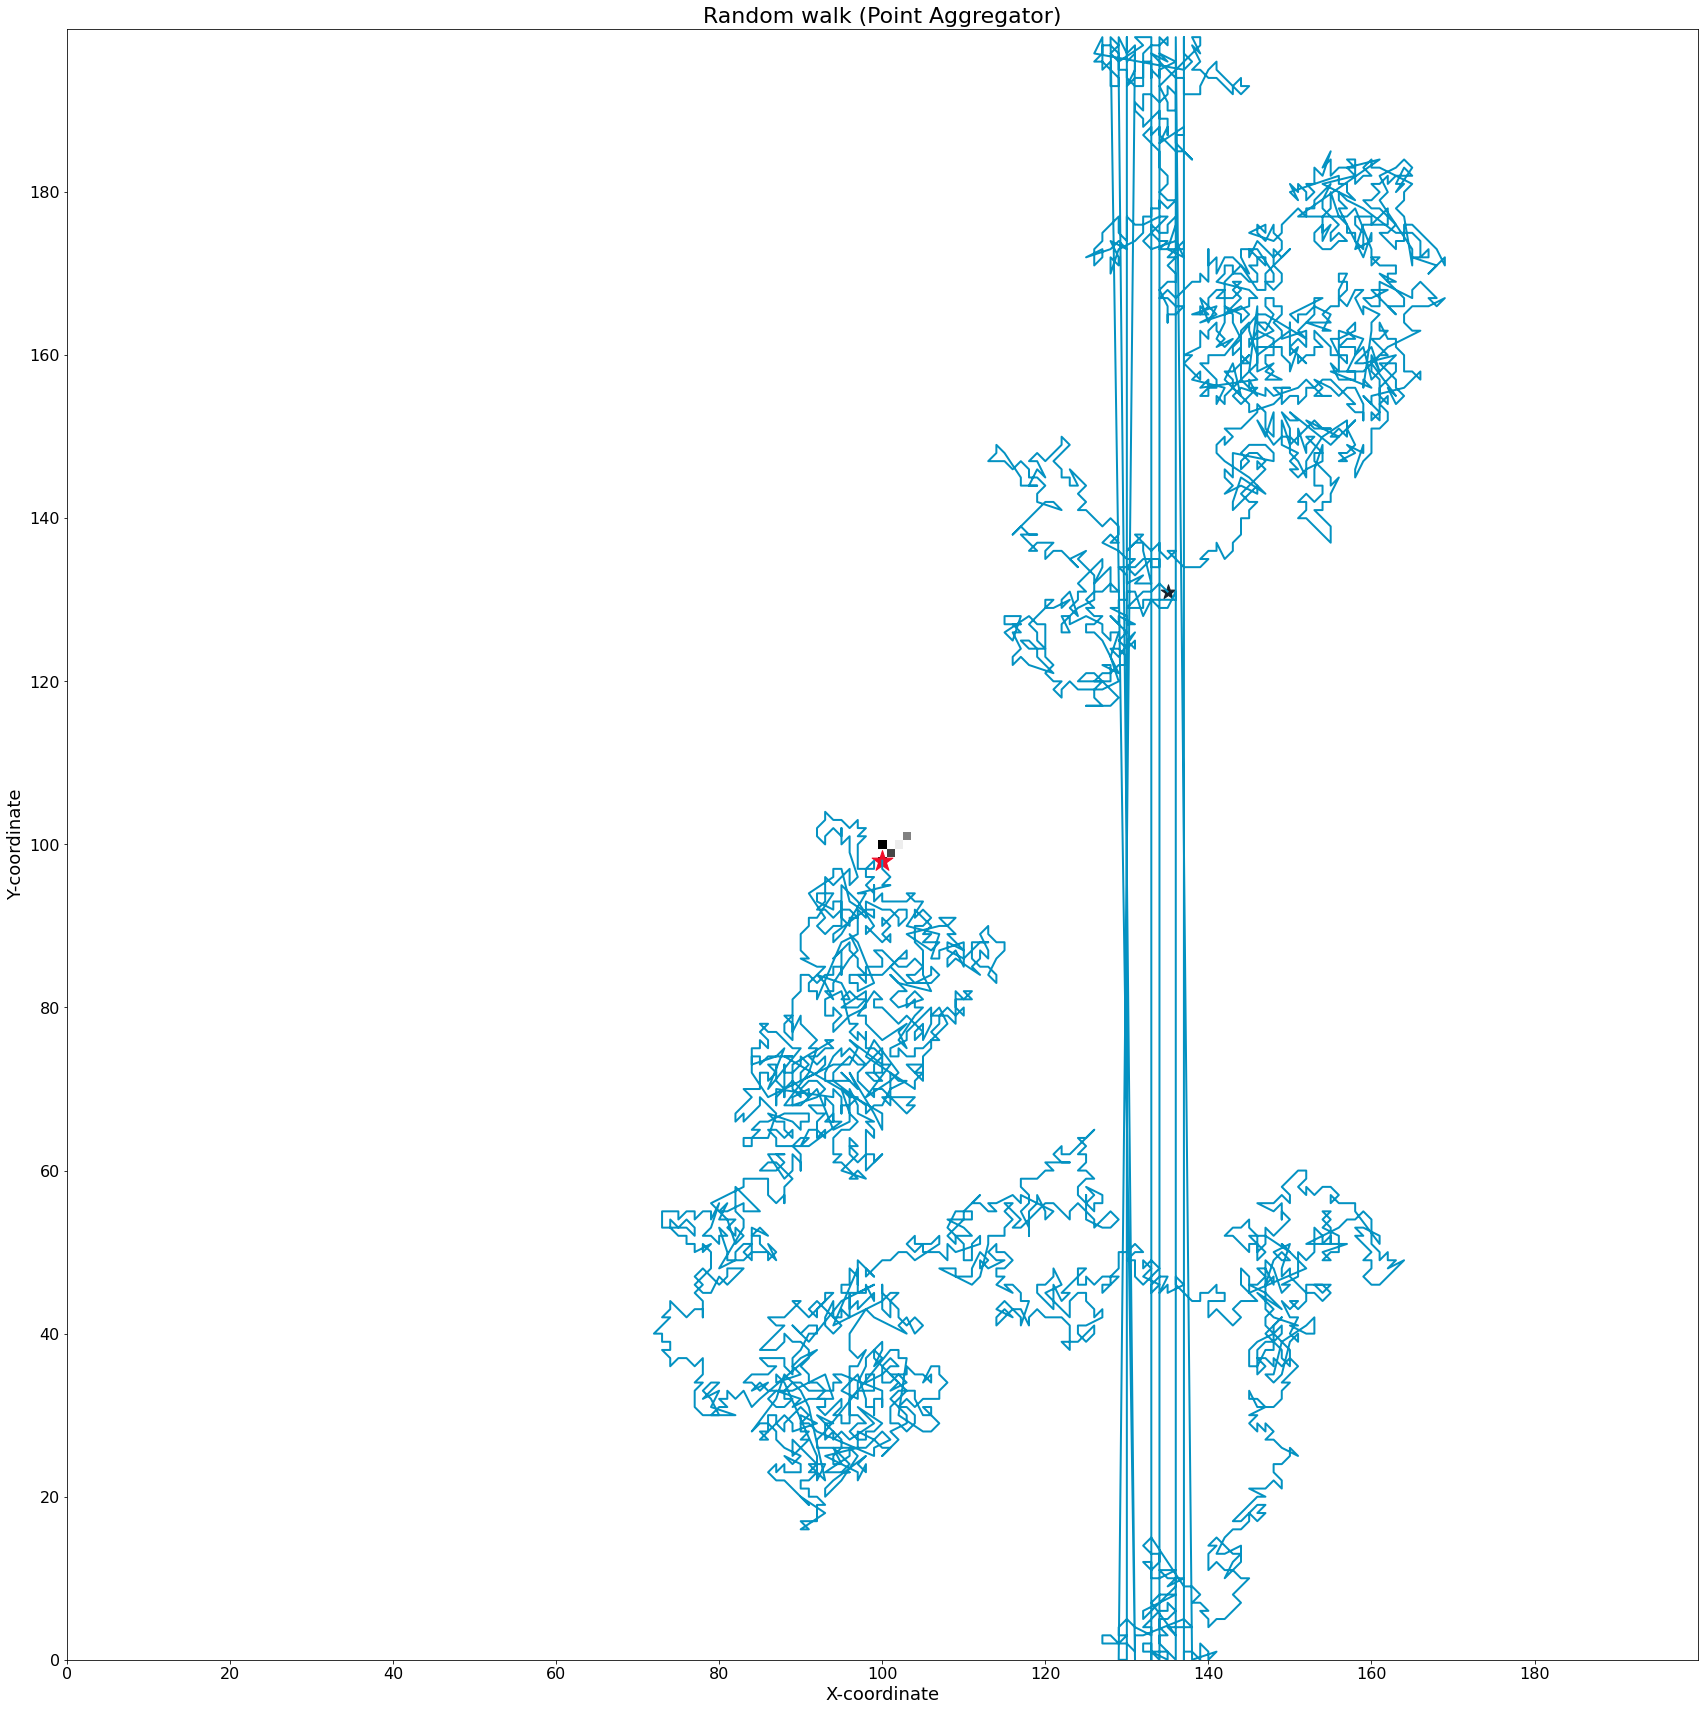

In [6]:
new_dla.trace_point(point=4)

## Task 2: An algorithm to estimate the "stickiness" parameter

In [7]:
import os
import re
from PIL import Image
from typing import Union

### Create a helper module to generate dataset for estimating stickiness

**pseudocode**

```
InferImage{
    read the image/matrix n x n
    take a filter m x m at center #As this is a point aggregator
    Slice the matrix of shape m x m
    calculate
        surface area of m x m
        crowd density of m x m
        total point used on matrix n x n
```
- use `DLA2d` to create an image and the user `InferImage` to get the remaining datapoint
- generate the dataset

In [8]:
class InferImage:
    def __init__(self, image:Union[np.ndarray, str], filter_size:int):
        if (filter_size % 3) != 0:
            filter_size = filter_size - 1
        self.filter_size = filter_size
        if isinstance(image, str):
            img = Image.open(image)
            img = img.convert("L")
            self.image = np.array(img)
        else:
            self.image = copy.deepcopy(image)
        
    def sliced_matrix(self):
        if self.filter_size <= self.image.shape[0]:
            middle_point = self.image.shape[0]//2
            half_filter_size = self.filter_size//2
            a = middle_point-half_filter_size
            b = middle_point+half_filter_size + 1
            return self.image[a:b, a:b]
        raise ValueError("Reduce filter size")
        
    def get_surface_area(self, matrix):
        return np.count_nonzero(matrix)
    
    def get_crowd_density(self, matrix):
        return self.get_surface_area(matrix)/(matrix.shape[0]**2)

The datase contains the following information:

**Given an image and filter size, all can be calculated.**

| Image | filter size | surface area | Crowd density of points | Total points used | Stickiness |
|-------|-------------|--------------|-------------------------|-------------------|------------|

- Image: Point aggregator image generated from the above algorithm
- filter size: filter matrix to crop image around center
- surface area: surface area of pixel in the filter area
- crowd density: crowd density of the points in the filter area
- Total points used: Total points used for the generation of image
- Stickiness: probablity with which a point is getting attached to another point

In [9]:
# save the dataset as a pandas dataframe
if not os.path.exists('dataset.pkl'):
    print("File doesn't exists. Creating a new file.")
    dataset = pd.DataFrame(columns=[
        'Image', 'filter size', 'surface area',
        'Crowd density of points', 'Total points used', 'Stickiness'])
    dataset.to_pickle("dataset.pkl")
else:
    dataset = pd.read_pickle("dataset.pkl")

File doesn't exists. Creating a new file.


In [10]:
# save the generated images at directory image_save_path
image_save_path = './Image/'
if not os.path.exists(image_save_path):
    print("Directory not present. Creating a new one.")
    os.mkdir(image_save_path)

Directory not present. Creating a new one.


In [11]:
initial_runs = 0
if not dataset.empty:
    initial_runs = int(max(dataset['Image'].str.extract(pat=r'(\d)', expand=False))) + 1
    print("{} images have aleady been generated.".format(initial_runs))
runs = 1000 + initial_runs
print("New images are to be generated with prefix starting from {} to {}".format(initial_runs, runs))

New images are to be generated with prefix starting from 0 to 1000


In [ ]:
# Run the loop to generate the data and change the matrix size after frequency of 100

matrix_size = 40
filter_size = 9
for run in range(initial_runs, runs):
    k = np.random.uniform(0.01, 1)
    dla = DLA2d(
        matrix_size=matrix_size,
        stickiness = k,
        points_to_generate = np.random.randint(matrix_size, 100))
    new_matrix = dla.initialize_matrix()
    mod_matrix = dla.generate_dla(matrix=new_matrix)
    file_name = image_save_path + "run_{}.png".format(run)
    plt.imsave(file_name, mod_matrix)
    
    infer = InferImage(
        image=mod_matrix,
        filter_size = filter_size)
    total_point = infer.get_surface_area(mod_matrix)
    slc_matrix = infer.sliced_matrix()
    surface_area = infer.get_surface_area(slc_matrix)
    crowd_density = infer.get_crowd_density(slc_matrix)
    
    dataset = dataset.append(
        {'Image': file_name,
         'filter size': infer.filter_size,
         'surface area': surface_area,
         'Crowd density of points': crowd_density,
         'Total points used': total_point,
         'Stickiness': dla.stickiness
        }, ignore_index=True
    )
    dataset.to_pickle("dataset.pkl")
    if run % 100 == 0:
        print("Run: {} completed.".format(run))
        matrix_size = matrix_size + 10
        filter_size = filter_size + 2
        print("New parameter")
        print("matrix({0}X{0}), filter({1}X{1})".format(matrix_size, filter_size))
    del dla, infer, new_matrix, mod_matrix, slc_matrix

### Subtask: A basic regression model to check the hypothesis
**Use a regression model to predict the stickiness in an image.**
- Provided an image, surface area, Crowd density of points, Total points used can be calculated for a given filter size. Using them a value can be predicted as a stickiness parameter

In [15]:
dataset = pd.read_pickle("dataset.pkl")
dataset.set_index("Image", inplace=True)

In [16]:
print(len(dataset))

11


In [17]:
dataset.head(2)

,filter size,surface area,Crowd density of points,Total points used,Stickiness
Image,,,,,
./Image/run_0.png,9,26,0.320988,49,0.472062
./Image/run_1.png,10,31,0.256198,95,0.844740


In [18]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import svm

In [19]:
scaler = MinMaxScaler()
data = scaler.fit_transform(dataset)

In [20]:
x_train, x_test, y_train, y_test = train_test_split(data[:,:-1], data[:,-1], test_size=0.3)

In [21]:
reg = svm.SVR(kernel='poly', verbose=True)

In [22]:
reg.fit(x_train, y_train)

[LibSVM]

SVR(kernel='poly', verbose=True)

In [23]:
# r2 coefficient
reg.score(x_test, y_test)

0.5529264044041904

**Comments**
- Generation of 1000 records was not completed, due to algorithm getting stuck during random walk at one of the edge condition.
- Due to less records, model created above is very unreliable. This is inferred with the r2 coefficient value.